# Hands-On Graph Attention Neural Network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%202%20-%20Graph%20Neural%20Networks/gat.ipynb)

En este notebook implementaremos una red grafal con el mecanismo de atención.

#### Referencias
- [Introduction: Hands-On Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing)
- [Pytorch Geometric - Colab Notebooks and Video Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)
- [Hands-On Graph Neural Networks Using Python](https://www.amazon.com/Hands-Graph-Neural-Networks-Python/dp/1804617520/ref=sr_1_1?crid=3A0QN1RYH7QQP&dib=eyJ2IjoiMSJ9.-qrnI2P8riRrQ4N6OPe1T9dfnkNhYgbD_-VhWVg_MfGU6D4U1TYZdUeJzAAZ1zhM7oyFoU7g3g3DppC-4DGSfmfmBfPUimLKlEKzBnujFTDHedtcSZuiN9EbIyNLxgkYbwfb0Nq4XhQQQZlS4JYFrBs0-rpkS8EmRz1o2OEJ0qrL9EXU9EJuj9cxCWt7J5HFE4nrJJYOPsX9aI78tp1LAEJqdUW14r9RbOYob9JQK0M.wej4dkKelg8wk6GVu5yxbMuiXefgjxhK-E-2n4_dFBs&dib_tag=se&keywords=hands+on+graph+neural+networks+using+python&qid=1713378267&sprefix=handson+gra%2Caps%2C197&sr=8-1)
- [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
- [How Attentive are Graph Attention Networks?](https://arxiv.org/abs/2105.14491)

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%202%20-%20Graph%20Neural%20Networks/requirements.txt && pip install -r requirements.txt

In [3]:
if IN_COLAB:
    import torch

    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Funciones utilitarias

Primero, definimos unas cuantas funciones utilitarias para visualizar los grafos. Simplemente añadimos una función más para dibujar más de un grafo a la vez.

In [4]:
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Any, Dict, Tuple
from torch_geometric.data import Dataset
from torch_geometric.data.data import BaseData

seed = 126534
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


def visualize_graph(G, color: str):
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, k=0.15, iterations=200, seed=1234),
        node_size=10,
        with_labels=False,
        node_color=color,
        cmap="Set2",
        width=0.15
    )
    plt.show()


def visualize_graphs(graphs: Dict[str, Dict[str, Any]]):
    fig, axs = plt.subplots(nrows=1, ncols=len(graphs), figsize=(30, 10))
    axs = axs.flatten()
    for idx, key in enumerate(graphs.keys()):
        G = graphs[key]['graph']
        classes = graphs[key]['classes']
        nx.draw_networkx(
            G,
            pos=nx.spring_layout(G, k=0.15, iterations=200, seed=1234),
            node_size=10,
            with_labels=False,
            node_color=classes,
            cmap="Set2",
            width=0.15,
            ax=axs[idx]
        )
        axs[idx].set_title(key)

    plt.show()


## Planetoid Cora Dataset

Este dataset es el equivalente al MNIST para graph learning. Consiste en una red de publicaciones cientificas y su respectivo tema que los caracteriza. En el subconjunto que vamos a usar en este notebook, hay siete categorías de publicaciones, organizadas de la siguiente manera:

- 0: Theory
- 1: Reinforcement Learning
- 2: Genetic Algorithms
- 3: Neural Networks
- 4: Probabilistic Methods
- 5: Case Based
- 6: Rule Learning

La librería Pytorch Geometric implementa unas funciones que nos facilitan la obtención y trabajo de este dataset. Y con ayuda de las funciones que hemos definido arriba, podrémos obtener información general sobre el conjunto de datos.

#### Referencias
- [The Cora Dataset](https://graphsandnetworks.com/the-cora-dataset/)

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='.', name='Cora')
data = dataset[0]

Ahora, visualicemos el grafo.

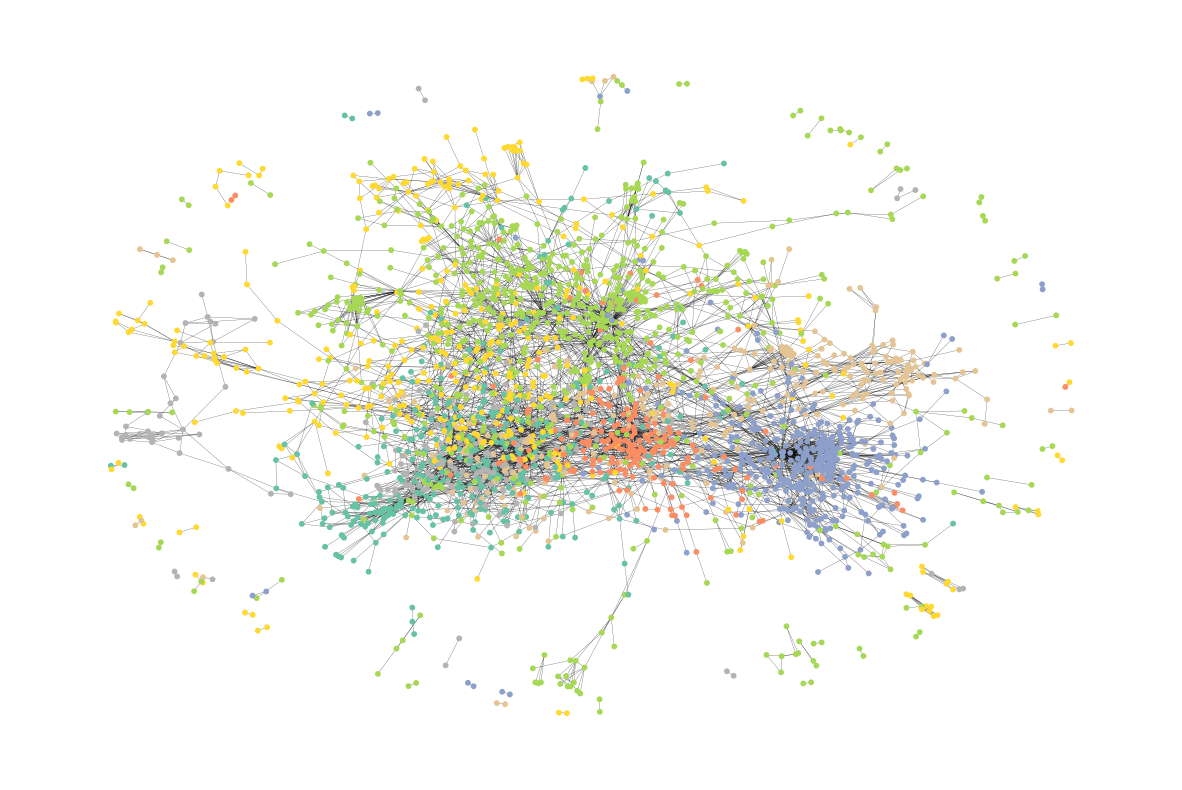

In [6]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

Este dataset empieza a ser lo suficientemente grande como para que con una visualización estática como la ofrecida por Networkx sea insuficiente para apreciarlo bien. Para visualizarlo completamente, es mejor exportar el grafo y visualizarlo en una herramienta externa como [yEd Live](https://www.yworks.com/yed-live/) o [Gephi](https://gephi.org). Aquí exportamos el grafo en formato `graphml` el cual podemos usar para importarlo en las herramientas mencionadas.

También se puede intentar visualizar con librerías interactivas como [pyvis](https://pyvis.readthedocs.io/en/latest/). Pero esto está por fuera el alcance de este notebook.

### Definición de una GCN

Como es constumbre, para efectos comparativos, entrenaremos primero una red GCN.

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch_geometric.data.lightning import LightningNodeData
from torchmetrics import Accuracy
from torch_geometric.nn import GCNConv


class GCN(LightningModule):

    def __init__(self, input_size: int, h_size: int, output_size: int):
        super(GCN, self).__init__()
        self.gcn1 = GCNConv(input_size, h_size)
        self.gcn2 = GCNConv(h_size, output_size)

        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)

        self.hparams['gcn1'] = str(self.gcn1)
        self.hparams['gcn2'] = str(self.gcn2)
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, edge_index) -> torch.Tensor:
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = F.cross_entropy(y_hat[batch.train_mask], y[batch.train_mask])
        self.train_acc(y_hat[batch.train_mask], y[batch.train_mask])
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        self.val_acc(y_hat[batch.val_mask], y[batch.val_mask])
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        self.test_acc(y_hat[batch.test_mask], y[batch.test_mask])
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

gcn_model = GCN(dataset.num_features, 32, dataset.num_classes)
tb_logger = TensorBoardLogger('tb_logs', name='GCN')
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger)

datamodule = LightningNodeData(
    data,
    input_train_nodes=data.train_mask,
    input_val_nodes=data.val_mask,
    input_test_nodes=data.test_mask,
    loader='neighbor',
    num_neighbors=[25, 10],
    batch_size=1024,
    num_workers=8
)
trainer.fit(gcn_model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/GCN
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | gcn1      | GCNConv            | 45.9 K
1 | gcn2      | GCNConv            | 231   
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
46.1 K    Trainable params
0         Non-trainable params
46.1 K    Total params
0.184     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s, v_num=0, val-acc=0.780, train-loss=0.00995, train-acc=1.000]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s, v_num=0, val-acc=0.780, train-loss=0.00995, train-acc=1.000]


In [19]:
gcn_model.eval()
result = trainer.test(gcn_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.8040000200271606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Definición de un modelo GAT

Ahora definiremos nuestro modelo GAT. Recordemos que, para un solo nodo $i$:

$$
v_i=\sum_{j\in N(i)} \alpha_{ij} Wx_j
$$

Siendo $\alpha_{ij}$ el attention score entre los nodos $i$ y $j$, cuya descomposición es:

$$
\alpha_{ij} = softmax_j(e_{ij}) = \frac{\exp{(e_{ij})}}{\sum_{k \in N_i}\exp{(e_{ik})}}
$$

$$
e_{ij} = LeakyReLU(a_{ij})
$$

$$
a_{ij} = W_{att}^T[Wx_i||Wx_j]
$$

Donde:
- La matriz $W$ son parámetros entrenables para la red que proyectan los embeddings de $i$ y $j$ en un espacio dimensional reducido.
- La matriz $W_{att}$ son parámetros entrenables aplicables a la concatenación de las matrices $Wx_i$ y $Wx_j$


In [9]:
from torch_geometric.nn import GATConv, GATv2Conv

class GATModel(LightningModule):

    def __init__(self, 
                 input_size: int, 
                 h_size: int, 
                 output_size: int, 
                 first_heads: int = 8,
                 second_heads: int = 1,
                 second_concat: bool = True,
                 use_v2: bool = False):
        super(GATModel, self).__init__()
        gat1_args = {
            'in_channels': input_size,
            'out_channels': h_size,
            'heads': first_heads
        }

        gat2_args = {
            'in_channels': h_size * first_heads,
            'out_channels': output_size,
            'heads': second_heads,
            'concat': second_concat
        }
        self.gat1 = GATv2Conv(**gat1_args) if use_v2 else GATConv(**gat1_args)
        self.gat2 = GATv2Conv(**gat2_args) if use_v2 else GATConv(**gat2_args)

        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)

        self.hparams['gat1'] = str(self.gat1)
        self.hparams['gat2'] = str(self.gat2)
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, edge_index) -> torch.Tensor:
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
    

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = F.cross_entropy(y_hat[batch.train_mask], y[batch.train_mask])
        self.train_acc(y_hat[batch.train_mask], y[batch.train_mask])
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        self.val_acc(y_hat[batch.val_mask], y[batch.val_mask])
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        self.test_acc(y_hat[batch.test_mask], y[batch.test_mask])
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

gat_model = GATModel(dataset.num_features, 32, dataset.num_classes)
tb_logger = TensorBoardLogger('tb_logs', name='GAT')
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger)

trainer.fit(gat_model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/GAT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | gat1      | GATConv            | 367 K 
1 | gat2      | GATConv            | 1.8 K 
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.478     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s, v_num=0, val-acc=0.770, train-loss=0.00943, train-acc=1.000]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s, v_num=0, val-acc=0.770, train-loss=0.00943, train-acc=1.000]


In [20]:
gat_model.eval()
result = trainer.test(gat_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.7829999923706055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Capas GATv2Conv

Según los autores en el paper ["How Attentive are Graph Attention Networks?"](https://arxiv.org/abs/2105.14491), la definición original de `GATConv` sufre de un problema con el mecanísmo de atención que es estático. Esto significa que el attention score del vecindario de $i$ es calculado independientemente del mismo nodo $i$. `GATv2Conv` propone un re-arreglo de parámetros en la formula que en teoría haría que el mecanísmo de atención fuera dinámico. El cambio específicamente consiste en:

GAT Tradicional:
$$
e(h_i, h_j) = \text{LeakyReLU}(a^T \cdot [Wh_i||Wh_j])
$$

GAT v2:
$$
e(h_i, h_j) = a^T \cdot \text{LeakyReLU}(W \cdot [h_i||h_j])
$$

Donde $a^T$ es equivalente a $W_{att}$ mencionada anteriormente. En esencia, lo que cambia es que ahora $W$ se aplica directamente sobre la concatenación en lugar de los embeddings de forma individual y la matriz de atención se aplica *despues* de la no-linealidad.

Los autores de esta segunda versión sostienen que GATv2 es más estable, comparada con la forma tradicional.

In [11]:
gat2_model = GATModel(dataset.num_features, 32, dataset.num_classes, use_v2=True)
tb_logger = TensorBoardLogger('tb_logs', name='GATV2')
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger)

trainer.fit(gat2_model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/GATV2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | gat1      | GATv2Conv          | 734 K 
1 | gat2      | GATv2Conv          | 3.6 K 
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
738 K     Trainable params
0         Non-trainable params
738 K     Total params
2.953     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, v_num=0, val-acc=0.784, train-loss=0.0314, train-acc=0.993] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s, v_num=0, val-acc=0.784, train-loss=0.0314, train-acc=0.993]


In [21]:
gat2_model.eval()
result = trainer.test(gat2_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.81it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.8230000138282776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


En este caso, la diferencia entre GCN y GAT se hace más pequeña aún y no siempre mejora.

### Observando el proceso de entrenamiento

In [13]:
%load_ext tensorboard

In [14]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 1769446), started 5:23:42 ago. (Use '!kill 1769446' to kill it.)

Para estos experimentos, hemos dejado que los tres modelos se entrenen por la misma cantidad de épocas. Las comparaciones entre estos modelos comienza a hacerse cada vez más difícil. Dependiendo del random seed asignado y la inicialización de parámetros en las redes, podemos llegar a obtener resultados muy diferentes.

### Haciendo predicciones

In [22]:
test_indices = data.test_mask.nonzero(as_tuple=False).squeeze()
test_nodes = data.x
test_edges = data.edge_index[:, test_indices.tolist()].T.tolist()
test_y = data.y[data.test_mask]

In [23]:
def build_output_graph(data, targets):
    graph = nx.Graph()
    for source, target in data.edge_index.T.tolist():
        if data.test_mask[source] and data.test_mask[target]:
            graph.add_edge(source, target)

    classes = []
    for node in graph.nodes:
        classes.append(targets[node])

    return graph, classes

In [24]:
# Ground Truth
test_graph, test_classes = build_output_graph(data, data.y)


# Predicciones GCN
gcn_pred = gcn_model(data.x, data.edge_index)
gcn_pred = gcn_pred[data.test_mask]
gcn_pred = torch.argmax(gcn_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), gcn_pred.tolist()))
gcn_graph, gcn_preds = build_output_graph(data, node_preds)

# Predicciones GATConv
gat_pred = gat_model(data.x, data.edge_index)
gat_pred = gat_pred[data.test_mask]
gat_pred = torch.argmax(gat_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), gat_pred.tolist()))
gat_graph, gat_preds = build_output_graph(data, node_preds)

# Predicciones GATv2Conv
gat2_pred = gat2_model(data.x, data.edge_index)
gat2_pred = gat2_pred[data.test_mask]
gat2_pred = torch.argmax(gat2_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), gat_pred.tolist()))
gat2_graph, gat2_preds = build_output_graph(data, node_preds)

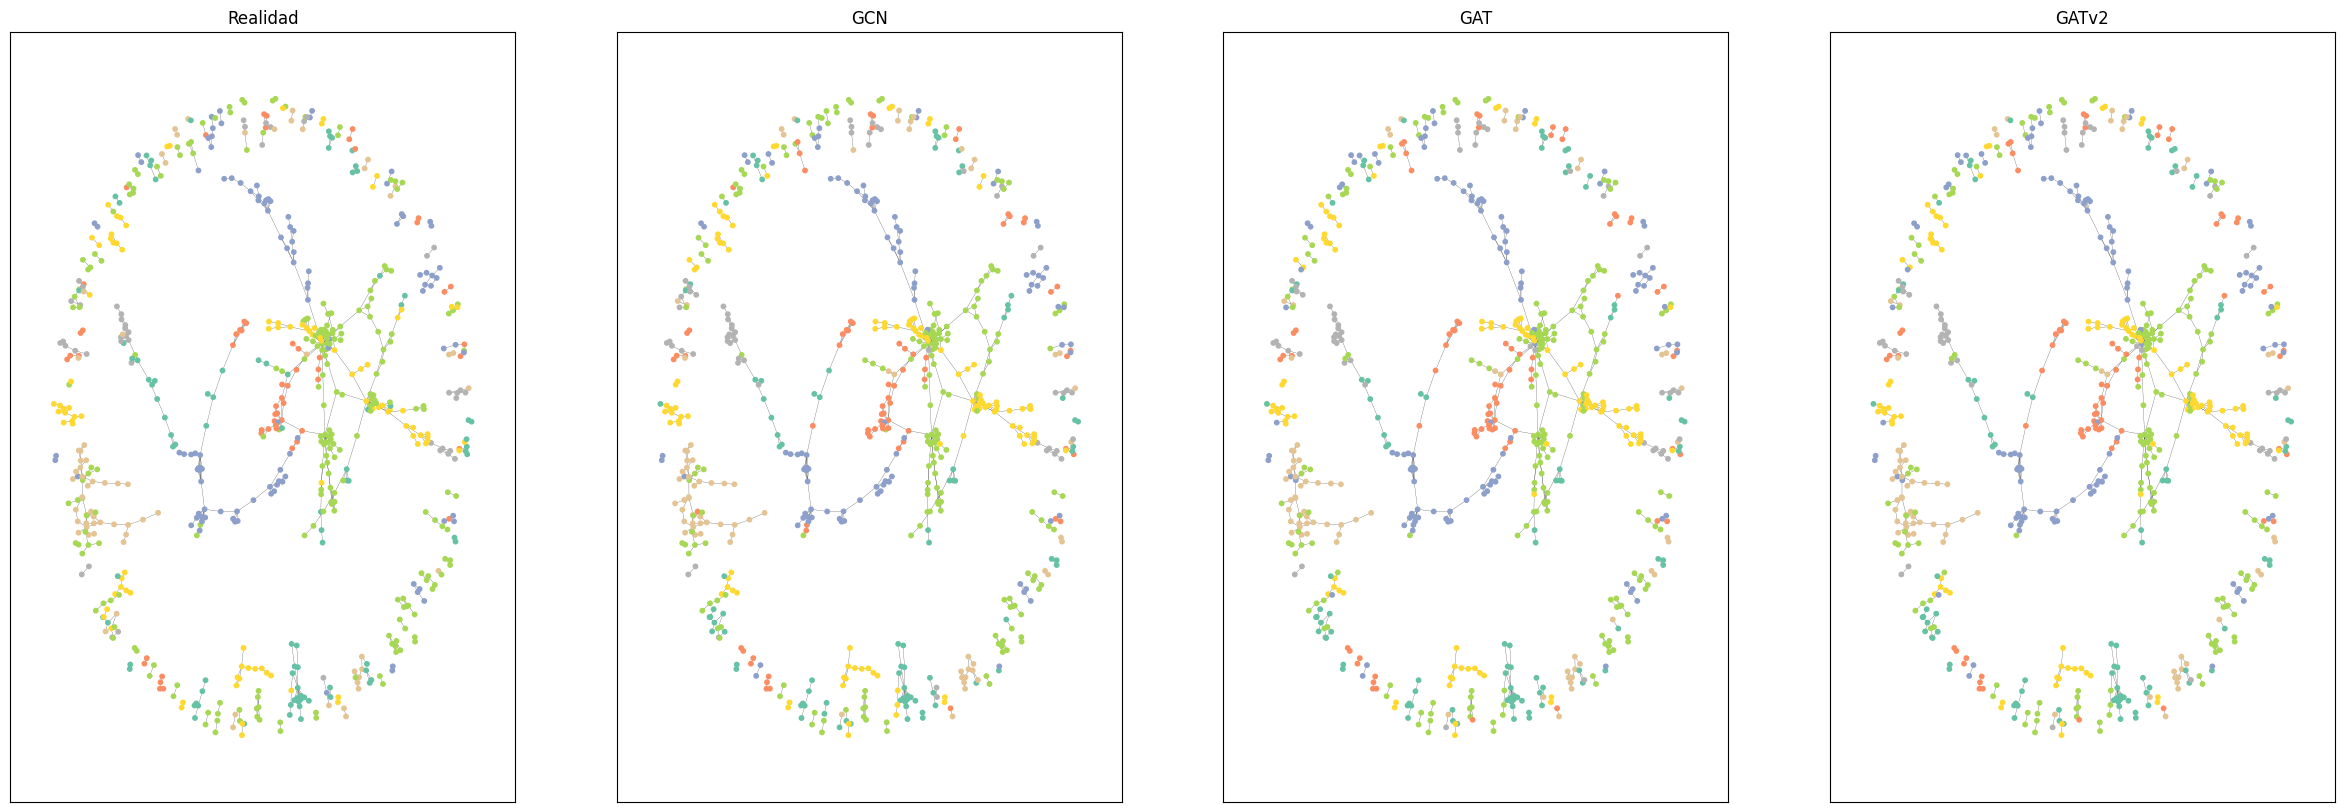

In [25]:
visualize_graphs(
    {
        'Realidad': dict(graph=test_graph, classes=test_classes), 
        'GCN': dict(graph=gcn_graph, classes=gcn_preds),
        'GAT': dict(graph=gat_graph, classes=gat_preds),
        'GATv2': dict(graph=gat2_graph, classes=gat2_preds),
        }
)

## Conclusiones

| GCN | GATConv | GATv2Conv |
|-------------|-----|----------|
|~79%         |~78% (+- 2) |~80% (+- 2)     |

- Dados los resultados, inicialmente podemos concluir que las capas GAT ocasionalmente ofrecen un ligero empuje en la tasa de correctitud para la tarea.
- En todos los casos explorados, se trabajó con modelos simples, de solo dos capas de GNN, incrementar la complejidad del modelo y probar diferentes combinaciones de hiper-parámetros podría ayudar a mejorar la calidad del modelo.
- Hay muchos factores que pueden influir en los resultados obtenidos, para poder sacar conclusiones significativas haría falta correr varios experimentos y buscar significancia estadística en los resultados. Muchas veces los enunciados en los papers son difíciles de reproducir en parte por estos detalles y se hace necesario probar con diferentes configurationes para saber cual capa nos sirver más para el caso en particular.